[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Abade_and_Albuquerque_2024/fig_2.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Abade_and_Albuquerque_2024/fig_2.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Abade_and_Albuquerque_2024/fig_2.ipynb)

#### based on Fig. 2 from Abade & Albuquerque 2024 (QJRMS)  "_Persistent mixed‐phase states in adiabatic cloud parcels under idealised conditions_"

(work in progress!)

https://doi.org/10.1002/qj.4775

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot
from PySDM.physics import si, in_unit
from PySDM_examples.Abade_and_Albuquerque_2024 import Simulation, Settings

In [12]:
simulations = {
    'Bulk': Simulation(Settings(
        timestep=1 * si.s,
        n_sd=100,
        enable_immersion_freezing=False,
        enable_vapour_deposition_on_ice=False,
    )),
    'Homogeneous': Simulation(Settings(
        timestep=.01 * si.s,
        n_sd=100,
        enable_immersion_freezing=True,
        enable_vapour_deposition_on_ice=True,
    )),
}

output = {
    key: val.run(nt=int(6000 * si.s / val.particulator.dt), steps_per_output_interval=500)
    for key, val in simulations.items()
}

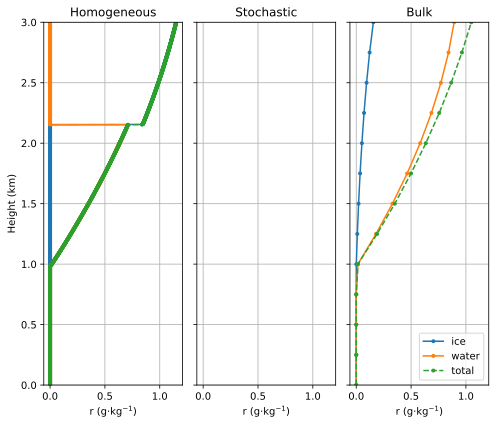

In [13]:
fig, axs = pyplot.subplot_mosaic(
    (('Homogeneous', 'Stochastic', 'Bulk'),),
    figsize=(7, 6),
    sharex=True,
    sharey=True,
    tight_layout=True,
)

ax = None
for label, ax in reversed(axs.items()):
    ax.set_xlabel(r"r (g$\cdot$kg$^{-1}$)")
    ax.set_title(label)
    ax.set_ylim(0, 3)
    ax.grid()
ax.set_ylabel('Height (km)')

values = {}

# Homogeneous
for name in ('ice', 'water', 'total'):
    total = np.asarray(output['Homogeneous']['water']) + np.asarray(output['Homogeneous']['ice'])
    axs['Homogeneous'].plot(
        in_unit(np.asarray(output['Homogeneous'][name] if name != 'total' else total), si.g / si.kg),
        in_unit(np.asarray(output['Homogeneous']['height']), si.km),
        label=name,
        marker='.',
        linestyle='--' if name == 'total' else '-'
    )

# Bulk
liquid_fraction = simulations['Bulk'].particulator.formulae.bulk_phase_partitioning.liquid_fraction(np.asarray(output['Bulk']['T']))
total_water_mixing_ratio = np.asarray(output['Bulk']['water'])
for name in ('ice', 'water', 'total'):
    values[name] = {
        'total': total_water_mixing_ratio,
        'ice': (1 - liquid_fraction) * total_water_mixing_ratio,
        'water': liquid_fraction * total_water_mixing_ratio
    }[name]
    
    axs['Bulk'].plot(
        in_unit(values[name], si.g / si.kg),
        in_unit(np.asarray(output['Bulk']['height']), si.km),
        label=name,
        marker='.',
        linestyle='--' if name == 'total' else '-'
    )
axs['Bulk'].legend()

show_plot('fig_2.pdf')

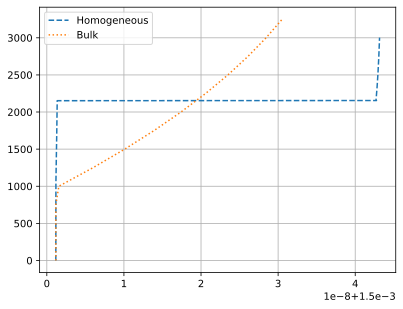

In [14]:
for key in ('Homogeneous', 'Bulk'):
    pyplot.plot(
        np.asarray(output[key]['vapour']) + np.asarray(output[key]['water']) + np.asarray(output[key]['ice']),
        output[key]['height'],
        label=key,
        linestyle=':' if key[0] == 'B' else '--'
    )
pyplot.legend()
pyplot.grid()